# Info
Purpose:

    Analyze ARISE data for ARCSIX, with new parameters retrievals.

Input:

    arguments

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - hdf5storage
    - scipy

Needed Files:
  - file.rc : for consistent creation of look of matplotlib figures
  - ...

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2021-08-31
    Modified:


# Prepare python environment

In [3]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import os


In [8]:
name = 'ARISE'
vv = 'v1'
fp = getpath(name)


Return path named:  ARISE /data/sam/ARISE/


## Load custom python functions and my own

In [13]:
from importlib import reload 

In [113]:
reload(Sp)

<module 'Sp_parameters' from '/home/sam/python_codes/Sp_parameters.py'>

In [29]:
def param(sp,wvlin,iws=None,norm_1050=False):
    " Calculates the parameters from a spectrum."
    from linfit import linfit
    from Sp_parameters import nanmasked, norm2max, smooth, deriv, find_closest
    npar = 11
    #print 'lenght of sp and wvlin',sp.shape,wvlin.shape
    spc, mask = nanmasked(sp)
    try:
        if len(mask.shape)==3:
            mask = mask[:,0,0]
    except:
        pass
    wvl = wvlin[mask]
    if len(wvl)<600:
        par = np.zeros(npar)*np.nan
        return par
    try:
        norm = norm2max(spc,iws=iws)
    except ValueError:
        par = np.zeros(npar)*np.nan
        return par
    [i1000,i1077,i1493,i1600,i1200,i1300,i530,i610,
     i1565,i1634,i1193,i1198,i1236,i1248,i1270,i1644,
     i1050,i1040,i1065,i600,i870,i515] = find_closest(wvl,np.array([1000,1077,1493,1600,1200,1300,530,
                                                     610,1565,1634,1193,1198,1236,1248,
                                                     1270,1644,1050,1040,1065,600,870,515]))
    if norm_1050:
        if np.isnan(spc[i1050]) or not spc[i1050]:
            par = np.zeros(npar)*np.nan
            return par
        norm2 = spc/np.nanmean(spc[i1040:i1050])
    else:
        if np.isnan(spc[i1200]) or not spc[i1200]:
            par = np.zeros(npar)*np.nan
            return par
        norm2 = spc/spc[i1200]
    try:
        dsp = smooth(deriv(norm2,wvl/1000),2,nan=False,old=True)
    except:
        import pdb; pdb.set_trace()
    imaxwvl = np.argmax(spc)
    maxwvl = wvl[mask[imaxwvl]]
    # now calculate each parameter
    #fit0 = np.polyfit(np.array([wvl[i1000],wvl[i1077]]),np.array([norm2[i1000],norm2[i1077]]),1)
    #fit0_fn = np.poly1d(fit0)
    fit7 = np.polyfit(np.array([wvl[i1493],wvl[i1600]]),np.array([norm2[i1493],norm2[i1600]]),1)
    fit7_fn = np.poly1d(fit7)
    #fit8,z = linfit(wvl[i1000:i1077],dsp[i1000:i1077]) 
    fit9,z = linfit(wvl[i1200:i1300],dsp[i1200:i1300])
    fit10,z = linfit(wvl[i530:i610]/1000,norm[i530:i610])
    fit14,z = linfit(wvl[i1565:i1634],spc[i1565:i1634]/norm[i1565])
    par = [dsp[i1198],                                          # 2 deriv of rad normed to 1000 nm at 1198 nm (!=IDL version)
           dsp[i1493],                                          # 3 deriv of rad normed to 1000 nm at 1493 nm
           norm[i1198]/norm[i1236],                             # 4 ratio of normalized rad of 1198 nm / 1236 nm
           np.nanmean(norm[i1248:i1270]),                       # 5 mean of normalized rad between 1248 nm - 1270 nm
           np.nanmean(norm[i1565:i1644]),                       # 6 mean of normalized rad between 1565 nm - 1644 nm
           sum(norm2[i1493:i1600]-fit7_fn(wvl[i1493:i1600])),   # 8 curvature of rad normed to 1000 nm for 1493 nm - 1600 nm
           fit9[0],                                             # 10 slope of deriv of rad normed to 1000 nm, 1200 nm - 1300 nm
           fit10[0],                                            # 11 slope of normalized radiance between 530 nm - 610 nm
           norm[i600]/norm[i870],                               # 14 ratio of normalized radiance at 600 nm / 870 nm
           np.nanmin([0.003,fit14[0]]),                         # 15 slope of radiance / rad at 1565 between 1565 nm - 1634 nm
           spc[i515]]                                           # 16 radiance at 515 nm
    # do a check for bad points
    #if np.all(np.isnan(par[0:10])): 
        #par[14] = np.nan
        #par[15] = np.nan
    return par

# Load files

## Load the LUT

In [69]:
forceice = False
forceliq = True

In [10]:
ice_lut = hs.loadmat(fp+'model/v3_ice_mid_ARISE_lut.mat')

In [18]:
ice_lut.keys()

dict_keys(['irr_dn', 'irr_dn_diff', 'irr_up', 'phase', 'rad', 'ref', 'sza', 'tau', 'wvl', 'zout'])

In [20]:
ice_lut['sza']

array([70.52877937, 71.18093663, 71.79004314, 72.36029861, 72.89536482,
       73.3984504 , 73.87237979, 74.31964987, 74.74247671, 75.14283446])

In [24]:
s=0
sptemp = {}
sptemp['tau'] = ice_lut['tau']
sptemp['ref'] = ice_lut['ref']
sptemp['zout'] = ice_lut['zout']
sptemp['sza'] = ice_lut['sza']
sptemp['phase'] = ice_lut['phase']
sptemp['irr_dn_diff'] = ice_lut['irr_dn_diff'][:,:,:,:,:,s]
sptemp['irr_dn'] = ice_lut['irr_dn'][:,:,:,:,:,s]
sptemp['irr_up'] = ice_lut['irr_up'][:,:,:,:,:,s]
sptemp['wvl'] = ice_lut['wvl']
sptemp['rad'] = ice_lut['rad'][:,:,:,:,:,s]

In [55]:
sptemp['rad'].shape

(2, 1302, 3, 28, 34)

In [60]:
sptemp['rad'][0,400,0,:,:]

array([[ 5.02604818,  7.91278458, 10.72834587, 16.07165718, 22.1958065 ,
        27.50473785, 32.26013947, 36.39395523, 39.89253998, 42.95782089,
        46.00158691, 48.47359848, 51.0060997 , 53.17679596, 54.43485641,
        55.01821136, 55.09498978, 54.2232933 , 52.57424927, 50.56837845,
        48.46969604, 46.38618851, 41.64113617, 37.65368271, 34.33014679,
        31.52924538, 29.60082245, 27.10056114, 25.65435028, 23.75109673,
        21.12697601, 19.01950836, 15.83898258, 13.55388641],
       [ 4.43336678,  6.67510939,  8.96866036, 13.34172916, 18.46660805,
        23.25376701, 27.55954742, 31.51239967, 35.01805878, 38.15391922,
        41.48856354, 44.3538208 , 47.49930573, 50.52634048, 52.69312286,
        54.15602493, 55.05099869, 55.58128357, 54.99606323, 53.76563644,
        52.20074463, 50.47926712, 46.14987564, 42.23085785, 38.84784317,
        35.94016647, 33.89925385, 31.23479843, 29.67744637, 27.60770988,
        24.72421837, 22.37843704, 18.79361343, 16.18147659],
  

In [142]:
ic = Sp.Sp(sptemp)

1302 1302
in rad
(2, 1302, 3, 28, 34) 5 1302
1 in ui
(2, 1302, 3, 28, 34)


In [143]:
ic.params(param=param,liq_only=forceliq,ice_only=forceice)

Running Parameters


/home/sam/python_codes/Sp_parameters.py:609: UserWarning: Copying the parameters calculated for liquid LUT to the ice LUT, ice parameters will be lost
  par[1,:,:,:] = par[0,:,:,:]


In [144]:
ic.par.shape

(2, 28, 34, 11)

In [145]:
ic.param_hires()

Running parameter hires
(72,)
(59,)
Running interpolation on params: [########################################]100% -- Done! 


## Load the data

In [81]:
s = hs.loadmat(fp+'starzen/20140919starzen.mat')

In [146]:
sa = Sp.Sp(s)

1556 1556
in rads
(1954, 1556) 2 1556
1 in ui
(1954, 1556)
Calculating the utc times
No indexed good values, choosing all times that are greater than 0 and that are not parked
good length: 363 / 1954


In [147]:
sa.params(param=param)

Running Parameters


In [148]:
sa.airmass = 1.0/np.cos(sa.sza*np.pi/180.0)

In [149]:
meas = sa

# Plot out data

<IPython.core.display.Javascript object>


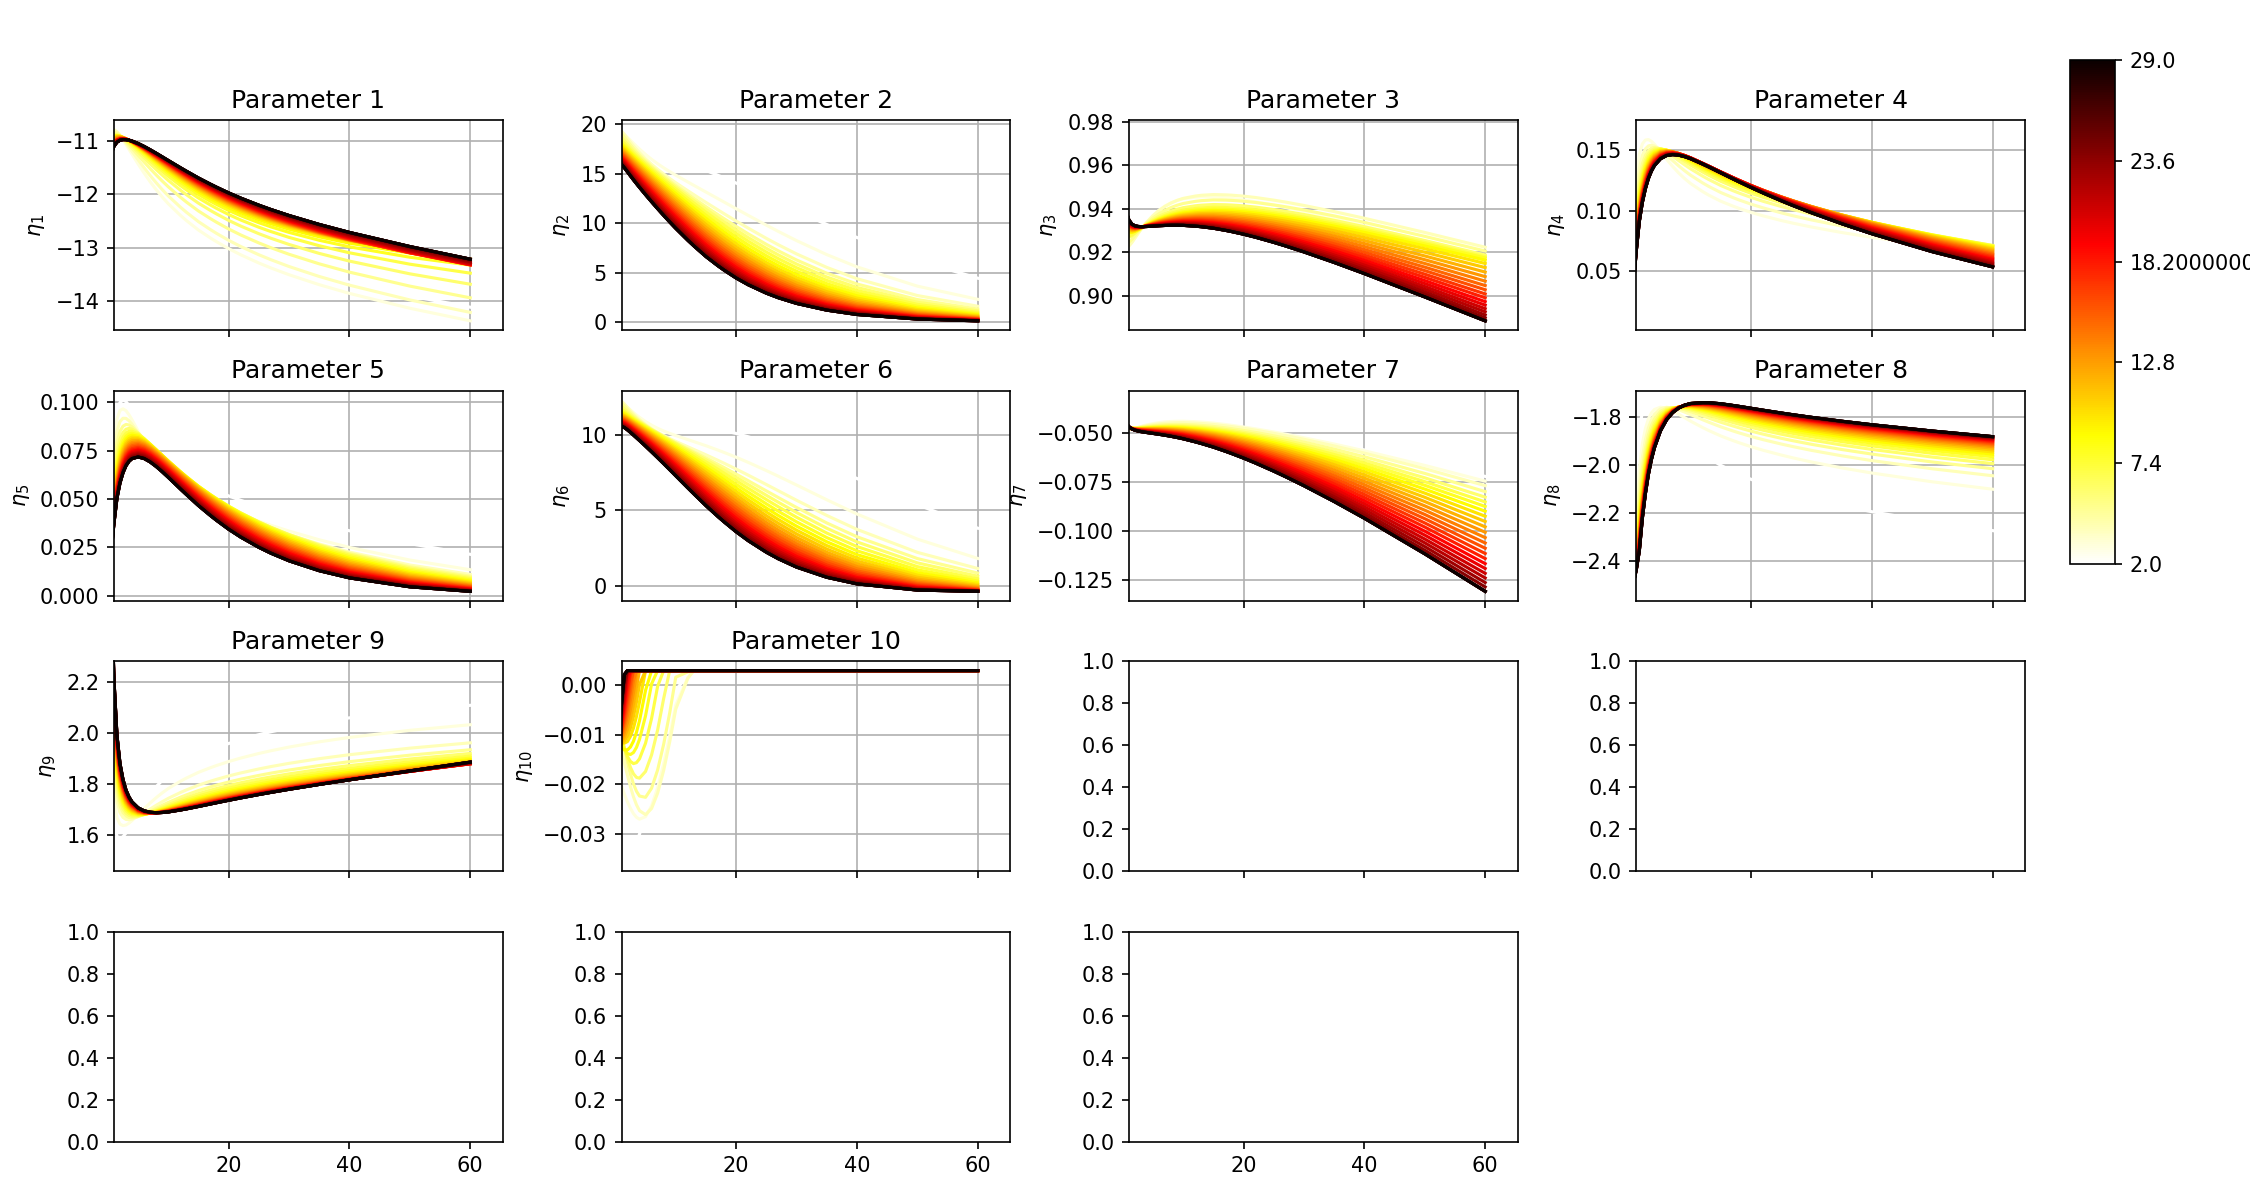

In [80]:
figl,axl = Sp.plot_lut_vs_tau(ic,forceliq=forceliq,forceice=forceice)

# make some retrievals

In [150]:
(meas.taut,meas.ref,meas.phase,meas.ki) = (np.zeros_like(meas.utc),np.zeros_like(meas.utc),\
                                           np.zeros_like(meas.utc),np.zeros_like(meas.utc))
(meas.taut,meas.ref,meas.phase,meas.ki) = (meas.taut*np.nan,meas.ref*np.nan,meas.phase*np.nan,meas.ki*np.nan)

In [151]:
meas.good

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   14,
         15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,
         26,   27,   28,   29,   30,   34,   35,   36,   37,   38,   39,
         40,   41,   42,   43,   44,   45,   46,   47,   48,   49,   50,
         51,   52,   53,   54,   55,   56,   57,   58,   59,   60,   61,
         62,   63,   64,   65,   66,   67,   68,   69,   70,   71,   72,
         73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,
         84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,
         95,   96,   97,   98,   99,  100,  101,  102,  103,  104,  105,
        106,  107,  108,  109,  110,  111,  112,  113,  114,  115,  116,
        117,  118,  119,  120,  121,  122,  123,  124,  125,  126,  127,
        128,  129,  130,  131,  132,  133,  134,  135,  136,  137,  138,
        139,  140,  141,  142,  143,  144,  145,  146,  147,  148,  149,
        150,  151,  152,  153,  154,  155,  156,  1

In [152]:
# filter
i500 = np.argmin(abs(meas.wvl-500))
i981,i982 = 1039,1040
sss = abs(meas.norm[meas.good,i981]-meas.norm[meas.good,i982])
flt = sss<0.1 #(meas.norm[meas.good,i500]>0.4) & (sss<0.1)
meas.good = meas.good[flt]

In [153]:
import run_kisq_retrieval as rk

In [155]:
print('meas.good lengh: {},meas.utc length: {}'.format(meas.good.shape,meas.utc.shape))
tau,ref,phase,ki = rk.run_retrieval(meas,ic,force_liq=forceliq,force_ice=forceice,subp=range(10))
meas.taut[meas.good] = tau[meas.good]
meas.ref[meas.good] = ref[meas.good]
meas.phase[meas.good] = phase[meas.good]
meas.ki[meas.good] = ki[meas.good]

meas.good lengh: (293,),meas.utc length: (1954,)
Retrieval progress over times: [########################################]100% -- Done! 


## Plot resulting retrievals

<IPython.core.display.Javascript object>


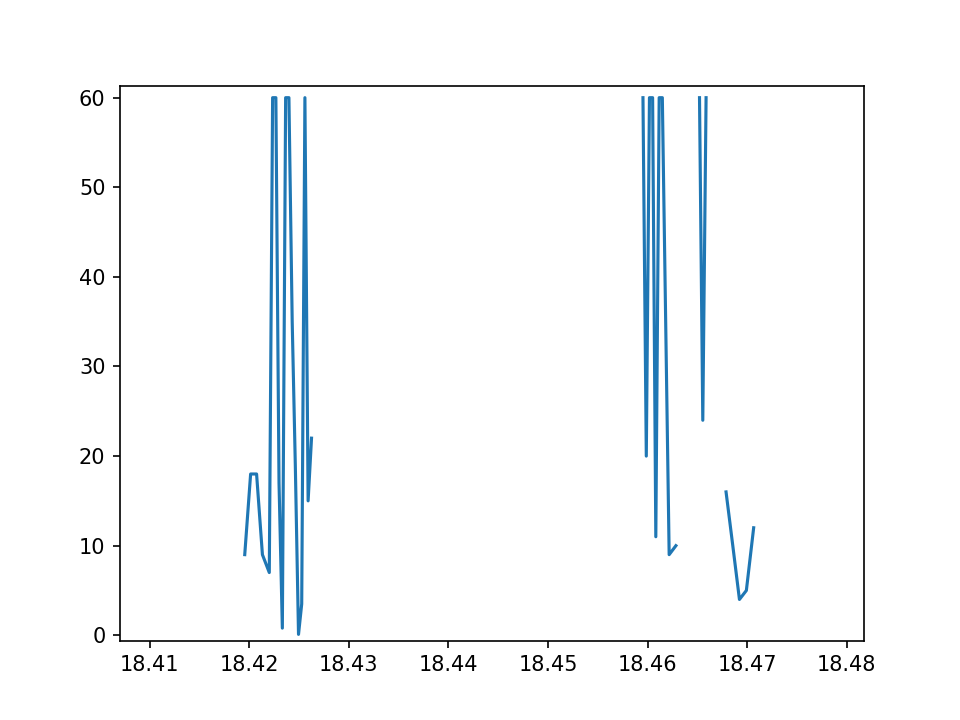

In [160]:
plt.figure()
plt.plot(meas.utc,meas.taut)

In [218]:
sum(meas.ki<15)

179

<IPython.core.display.Javascript object>


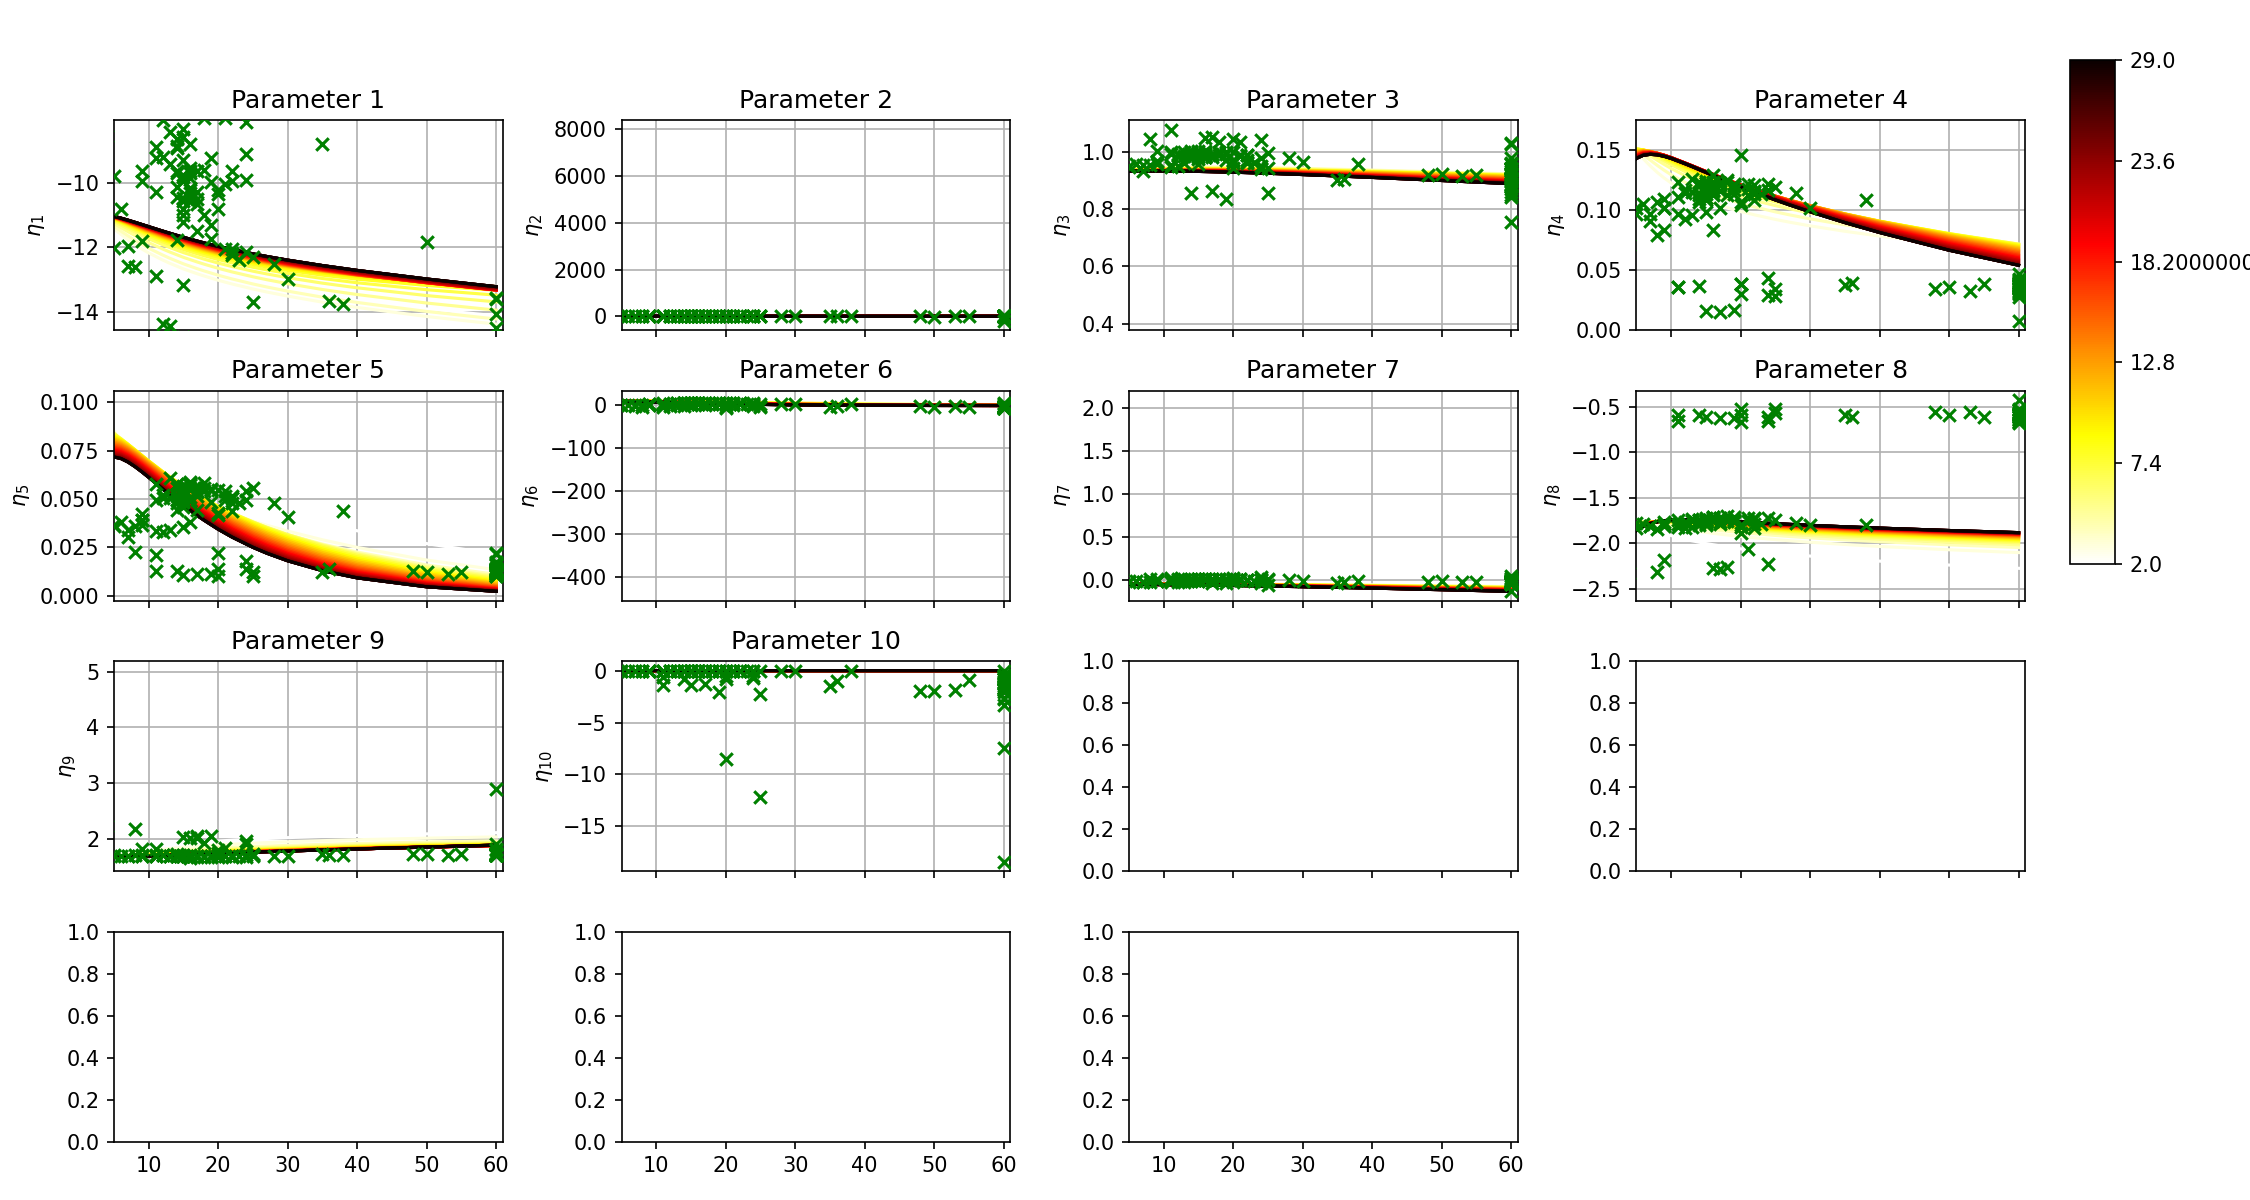

In [222]:
npar = 10
figl,axl = Sp.plot_lut_vs_tau(ic,forceliq=forceliq,forceice=forceice)
for ai,ax in enumerate(axl[0:npar]):
    #ax.scatter(meas.taut,meas.par[:,ai],marker='x',zorder=200,color='k')
    igg = meas.ki<10
    ax.scatter(meas.taut[igg],meas.par[igg,ai],marker='x',zorder=200,color='g')